# Machine Learning - Practical 4

Names: {altendorf-luckhardt-wibergh}

In [2]:
import sys
!{sys.executable} -m pip install cvxopt

  Using cached cvxopt-1.3.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.7 MB)


In [3]:
import numpy as np
import cvxopt
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import load_wine
from sklearn.tree import DecisionTreeClassifier
from numpy import linalg as LA

## Task 0: The Data

We will work with the data from Practical 3. Load the data and split it into a training and test set. You can re-use the data splitting function from Practical 2.

In [4]:
def split_data(X, y, frac=0.2, seed=1):
    if seed is not None:
        np.random.seed(seed)
        
    # ---------------- INSERT CODE ----------------------
    test_len=(int)(np.array(y).shape[0]*.3)
    idx = np.arange(X.shape[0])
    idx_shuffled = np.random.permutation(idx)  # shuffle indices to split into training and test set

    test_idx = idx_shuffled[:test_len]
    train_idx = idx_shuffled[test_len:]

    X_test = X[test_idx]
    y_test = y[test_idx]
    X_train = X[train_idx]
    y_train = y[train_idx]


    # ---------------- END CODE -------------------------
    
    return X_train, X_test, y_train, y_test

In [5]:
# load data
X_2d, t_2d = np.load('nonlin_2d_data.npy')[:,:2], np.load('nonlin_2d_data.npy')[:, 2]

In [6]:
# split data
X_train, X_test, t_train, t_test = split_data(X_2d, t_2d, seed=1)

In [7]:
len(X_train)

175

## Task 1: Support Vector Machines

First, you will implement a training algorithm for the Support Vector Machine (SVM). For solving the quadratic program, we provide a simple interface to the cvxopt library below.

In SVMs, each data sample $x_n$ has a corresponding lagrange multiplier $\alpha_n$ which indicates if $x_n$ is a support vector. In the latter case $\alpha_n > 0$ holds. 
The goal of learning the SVM is to figure out which samples are support vectors by learning $\mathbf{\alpha}$. The dual SVM optimizes the following quadratic program.

$$ \min \frac{1}{2} \sum_{n=1}^N \sum_{m=1}^N \alpha_n \alpha_m t_n t_m k(\mathbf{x}_n, \mathbf{x}_m) - \sum_{n=1}^N \alpha_n$$
subject to 
$$ 0 \leq \alpha_n \leq C $$
$$ \sum_{n=1}^N \alpha_n t_n = 0 $$ 

The quadratic program solver expects the following form:
$$ \min \frac{1}{2} \alpha^T P \alpha + \mathbf q^T \mathbf \alpha $$
subject to 

$$A \alpha = b$$
$$G \alpha \leq h $$

Here, $A$ and $G$ are matrices with one row per individual constraint. Similarly, $b$ (the intercept or bias) and $h$ are vectors with one element per individual constraint.

Having trained the SVM, a prediction for an input $\mathbf{x}$ is made by:

$$ y = sign([\sum_n^{N} \alpha_n t_n k(\mathbf{x}, \mathbf{x}_n)] + b)  $$


### Task 1.1
 
Use the code provided below as a basis to express the constrained optimization problem in terms of $P, q, A, b, G$ and $h$ and implement a function `fit_svm` which passes these variables to the provided QP solver. Fit a SVM on the training data and extract its parameters using a linear kernel (dot product).

**Hints:**
  - The box constraint $0 \leq \alpha_n \leq C$ defines two constraints of the form $G \alpha_n \leq h$ for each $\alpha_n$.
  - The inequality $x \geq 0$ is equivalent to $-x \leq 0$.
  - The SVM is described in chapter 12 of Elements of Statistical Learning.

In [8]:
def linear_kernel(a, b):
    # ---------------- INSERT CODE ----------------------


    return a.T@b

    # ---------------- END CODE -------------------------


def fit_svm(X, t, kernel, C=1.0):
    '''Fit SVM using data (X,t), specified kernel and parameter C.
    Inputs
        X:  predictors
        t:  targets
        C:  constant
    '''
    t=np.array([-1 if l == 0 else 1 for l in t])
    # ---------------- INSERT CODE ----------------------
    P=np.zeros((len(X),len(X)))
    for n in range(len(X)):
        for m in range(len(X)):
            P[n,m]=t[n]*t[m]*kernel(X[n],X[m])
    q = -1*np.ones(len(X))
    A = t.astype(float).reshape(1,-1)
    b = np.zeros((1,1))
    g1 = -1*np.identity(len(X))
    g2 = np.identity(len(X))
    G  = np.vstack((g1,g2))
    h1 = np.zeros(len(X))
    h2 = C*np.ones(len(X))
    h  = np.hstack((h1,h2))
    # ---------------- END CODE -------------------------
    
    assert P.shape == (len(X), len(X))
    assert len(q) == len(X)
    assert A.shape == (1, len(X)) and A.dtype == 'float'
    assert b.shape == (1, 1)
    assert len(G) == 2 * len(X)
    assert len(h) == 2 * len(X)

    return solve_quadratic_program(P, q, A, b, G, h)

def solve_quadratic_program(P, q, A, b, G, h):
    '''Uses cvxopt to solve the quadratic program.'''
    P, q, A, b, G, h = [cvxopt.matrix(var) for var in [P, q, A, b, G, h]]
    minimization = cvxopt.solvers.qp(P, q, G, h, A, b)
    lagr_mult = np.ravel(minimization['x'])
    return lagr_mult


def extract_parameters(X, t, kernel, lagr_mult, threshold=1e-7):
    '''Computes the intercept from the support vector constraints.
    
    Inputs
        X:         predictors
        t:         targets
        kernel:    a kernel to be used
        lagr_mult: the Lagrange multipliers obtained by solving the dual QP
        threshold: threshold for choosing support vectors
    
    Returns
        lagr_mult: lagrange multipliers for the support vectors
        svs:       set of support vectors
        sv_labels: targets t_n for the support vectors
        intercept: computed intercept (also called bias)
    '''
    t = np.array([-1 if l == 0 else 1 for l in t])
    
    # ---------------- INSERT CODE ----------------------
    svs=X[lagr_mult>threshold]
    sv_labels=t[lagr_mult>threshold]
    lagr_mult=lagr_mult[lagr_mult>threshold]
    intercept = 0
    print("Anzahl SV: ",len(svs))
    for n in range(len(svs)):
        summe=0
        for m in range(len(svs)):
            summe+=lagr_mult[m]*sv_labels[m]*kernel(svs[m],svs[n])
        intercept+=sv_labels[n]-summe
    intercept/=len(svs)
    
    # ---------------- END CODE -------------------------

    return lagr_mult, svs, sv_labels, intercept


In [9]:
# Training
# Fit SVM on training data
alpha_lin = fit_svm(X_train, t_train, linear_kernel, C=1.0)

# Extract parameters
lagr_mult_lin, svs_lin, sv_labels_lin, intercept_lin =extract_parameters(X_train, t_train, linear_kernel, alpha_lin)

     pcost       dcost       gap    pres   dres
 0: -1.6799e+02 -3.7889e+02  9e+02  2e+00  2e-14
 1: -1.2879e+02 -2.5279e+02  1e+02  2e-15  1e-14
 2: -1.3986e+02 -1.4886e+02  9e+00  2e-15  1e-14
 3: -1.4000e+02 -1.4009e+02  9e-02  8e-16  1e-14
 4: -1.4000e+02 -1.4000e+02  9e-04  3e-15  1e-14
 5: -1.4000e+02 -1.4000e+02  9e-06  3e-15  1e-14
Optimal solution found.
Anzahl SV:  175


In [10]:
t=np.array([-1 if l == 0 else 1 for l in t_test])

### Task 1.2

Having learnt an SVM, we can use the calculated parameters to make predictions on novel samples.
- Implement a function `svm_predict(X, kernel, lagr_mult, svs, sv_labels, intercept)`.
- Use this function with the linear kernel and compute the test accuracy on the 2d dataset.
- Visualize the samples form the test set in a scatter plot colored by your predictions

In [11]:
def svm_predict(X, kernel, lagr_mult, svs, sv_labels, intercept):
    ''' Given the learned parameters of the SVM, make a prediction on the test set.
    Inputs
        X:         predictors
        kernel:    a kernel to be used
        lagr_mult: the Lagrange multipliers obtained by solving the dual QP
        svs:       set of support vectors
        sv_labels: targets t_n for the support vectors
        intercept: computed intercept (also called bias)
    
    Returns
        prediction: predictions on novel samples
    '''  
    
    # ---------------- INSERT CODE ----------------------
    prediction = np.zeros(len(X))
    for i in range(len(X)):
        summe = 0
        for n in range(len(svs)):
            summe+=lagr_mult[n]*sv_labels[n]*kernel(svs[n],X[i])
        prediction[i]=summe+intercept
    prediction=np.sign(prediction)
    # ---------------- END CODE -------------------------
    
    return prediction

In [12]:
# Testing
# make predictions for test set
prediction_lin=svm_predict(X_test, linear_kernel, lagr_mult_lin, svs_lin, sv_labels_lin, intercept_lin)
print("Acc=",np.mean(prediction_lin==t))

Acc= 0.6


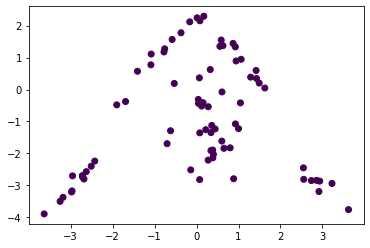

In [13]:
# visualize predictions
plt.scatter(X_test[:, 0], X_test[:, 1], c=prediction_lin)

### Task 1.3

- Instead of using the linear kernel, use the Gaussian RBF kernel defined in Practical 3.
- Compare results on with both kernels with sklearn implementation (SVC)
- Visualize the predictions on the test set, the learned support vectors and the decision boundary for both kernels (Hint: Adapt the decision boundary plot from Practical 3).

In [14]:
def rbf_kernel(a, b):
    # ---------------- INSERT CODE ----------------------
    return np.exp(-1*(LA.norm(a-b)**2))
    # ---------------- END CODE -------------------------

In [15]:
# Fit SVM with rbf kernel and calculate the test accuracy
alpha_rbf = fit_svm(X_train, t_train, rbf_kernel, C=1.0)
lagr_mult_rbf, svs_rbf, sv_labels_rbf, intercept_rbf =extract_parameters(X_train, t_train, rbf_kernel, alpha_rbf)
prediction_rbf=svm_predict(X_test, rbf_kernel, lagr_mult_rbf, svs_rbf, sv_labels_rbf, intercept_rbf)
print("acc=",np.mean(prediction_rbf==t))

     pcost       dcost       gap    pres   dres
 0: -7.2712e+00 -2.6619e+02  1e+03  2e+00  7e-16
 1: -1.8644e+00 -1.2007e+02  1e+02  2e-15  6e-16
 2: -7.7783e+00 -2.3113e+01  2e+01  2e-15  8e-16
 3: -9.3373e+00 -1.3684e+01  4e+00  1e-15  4e-16
 4: -1.0071e+01 -1.1056e+01  1e+00  4e-16  4e-16
 5: -1.0285e+01 -1.0635e+01  3e-01  1e-15  4e-16
 6: -1.0353e+01 -1.0475e+01  1e-01  4e-16  4e-16
 7: -1.0384e+01 -1.0412e+01  3e-02  5e-16  4e-16
 8: -1.0394e+01 -1.0396e+01  1e-03  3e-16  4e-16
 9: -1.0395e+01 -1.0395e+01  3e-05  7e-16  4e-16
10: -1.0395e+01 -1.0395e+01  5e-07  5e-16  4e-16
Optimal solution found.
Anzahl SV:  41
acc= 1.0


In [16]:
# Fit SVM using sklearn and calculate the test accuracy
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
clf = make_pipeline(StandardScaler(), SVC(kernel='rbf',gamma='auto'))
clf.fit(X_train, t_train)
print("sklearn score with rbf",clf.score(X_test,t_test))
clf = make_pipeline(StandardScaler(), SVC(kernel='linear',gamma='auto'))
clf.fit(X_train, t_train)
clf.score(X_test,t_test)
print("sklearn score with linear",clf.score(X_test,t_test))

sklearn score with rbf 1.0
sklearn score with linear 0.6


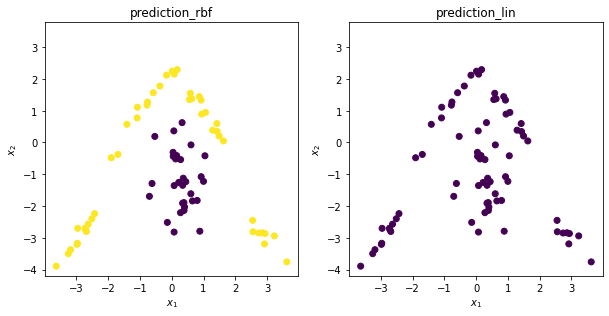

In [17]:
pred = [prediction_rbf,prediction_lin]
names = ["prediction_rbf","prediction_lin"]
fig,axes = plt.subplots(1,2,figsize=(10,5))
for i,ax in enumerate(axes):
    ax.scatter(X_test[:, 0], X_test[:, 1], c=pred[i])
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.axis('square');
    ax.set_title(names[i])

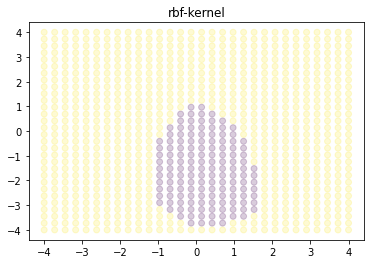

In [18]:
def plot_decision_boundary(predict_fn):
    ''' Plot decision boundary.

    predict_fn: function handle to a predict function that takes
                as input a data point x and outputs the predicted
                label t
    '''
    grid = np.meshgrid(np.linspace(-4, 4, 30), np.linspace(-4, 4, 30))
    grid_x, grid_y = grid[0].flatten(), grid[1].flatten()
    grid_t = np.array([
        predict_fn([[x, y]]) for x, y, in zip(grid_x, grid_y)])
    plt.scatter(grid_x, grid_y, c=grid_t, alpha=0.2)
    plt.title("rbf-kernel")

# The following example has the decision boundary at x[0] = 0.5
predict_fn = lambda x: svm_predict(x, rbf_kernel, lagr_mult_rbf, svs_rbf, sv_labels_rbf, intercept_rbf)
plot_decision_boundary(predict_fn)

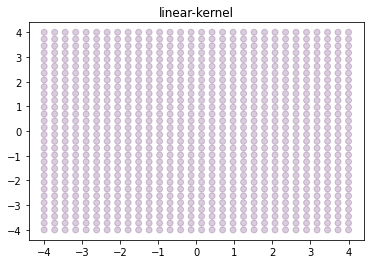

In [19]:
def plot_decision_boundary(predict_fn):
    ''' Plot decision boundary.

    predict_fn: function handle to a predict function that takes
                as input a data point x and outputs the predicted
                label t
    '''
    grid = np.meshgrid(np.linspace(-4, 4, 30), np.linspace(-4, 4, 30))
    grid_x, grid_y = grid[0].flatten(), grid[1].flatten()
    grid_t = np.array([
        predict_fn([[x, y]]) for x, y, in zip(grid_x, grid_y)])
    plt.scatter(grid_x, grid_y, c=grid_t, alpha=0.2)
    plt.title("linear-kernel")

# The following example has the decision boundary at x[0] = 0.5
predict_fn = lambda x: svm_predict(x, linear_kernel, lagr_mult_lin, svs_lin, sv_labels_lin, intercept_lin)
plot_decision_boundary(predict_fn)


# Task 2: Decision Trees

Next, we will implement a simple decision tree classifier using the Wine dataset, one of the standard sklearn datasets. 

We will use the Gini impurity as a criterion for splitting. It is defined for a set of labels as
$$ G = \sum_{i=0}^C p(i) * (1- p(i)) $$

Given labels $l$ and split $l_a$ and $l_b$, the weighted removed impurity can be computed by $G(l) - \frac{|l_a|}{|l|}G(l_a) - \frac{|l_b|}{|l|}G(l_b)$.

Here is a simple explanation of the Gini impurity that you may find useful: https://victorzhou.com/blog/gini-impurity/


### Task 2.1

1. Plot the distribution of the first feature of for each class of the wine dataset.
2. Implement a function `gini_impurity(t)` that computes the Gini impurity for an array of labels `t`.
3. Calculate the removed Gini impurity for a split after 50 samples, i.e. between `t[:50]` and `t[50:]`.

In [20]:
# Load Wine dataset and split into train+test set
X, t = load_wine(return_X_y=True)
X_train, X_test, t_train, t_test = split_data(X, t)

In [21]:
X.shape,np.unique(t)

((178, 13), array([0, 1, 2]))

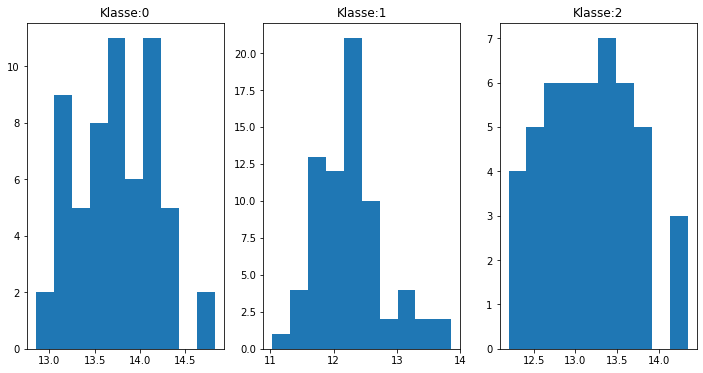

In [22]:
# Plot distribution
fig,ax = plt.subplots(1,3,figsize=(12,6))
for ind,clas1 in enumerate(np.unique(t)):
    ax[ind].hist(X[:,0][t==clas1])
    ax[ind].set_title("Klasse:%d"%clas1)
plt.show()

In [23]:
# Compute Gini impurity
def gini_impurity(t):
    gini = 0
    labels = np.unique(t)
    for lab in labels:
        gini+=(len(t[t==lab])/len(t))*(1-(len(t[t==lab])/len(t)))
    return gini
gini_impurity(t)

0.6583133442747128

Calculate the removed Gini impurity for a split after 50 samples, i.e. between t[:50] and t[50:].

In [24]:
split1 = t[:50]
split2 = t[50:]
removed = gini_impurity(t)-(len(split1)/len(t))*gini_impurity(split1)-(len(split2)/len(t))*gini_impurity(split2)
removed

0.2651426982072971

### Task 2.2
For each of the first 12 features, compute the remove Gini impurity for every possible split. Visualize the removed Gini impurity per feature across all splits. Which is the optimal split?

Text(0, 0.5, 'feature x')

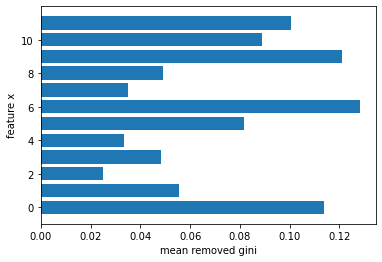

In [25]:
# Plotting
gini = []
ober_all =[]
for i in range(12):
    X_act = X[:,i]
    gini_act=[]
    ober_act=[]
    classes = np.unique(X_act)
    for ober in classes:
        split1=t[X_act<ober]
        split2=t[X_act>=ober]
        gini_act.append(gini_impurity(t)-(len(split1)/len(t))*gini_impurity(split1)-(len(split2)/len(t))*gini_impurity(split2))
        ober_act.append(ober)
    #gini_opt.append(np.argmin(gini_act)
    gini.append(gini_act)
    ober_all.append(ober_act)
means = []
maxes=[]
for i in range(12):
    means.append(np.mean(gini[i]))
    maxes.append(np.max(gini[i]))
max_feat = np.argmax(maxes)
max_val = np.max(maxes)
plt.barh(np.arange(12),means)
plt.xlabel("mean removed gini")
plt.ylabel("feature x")

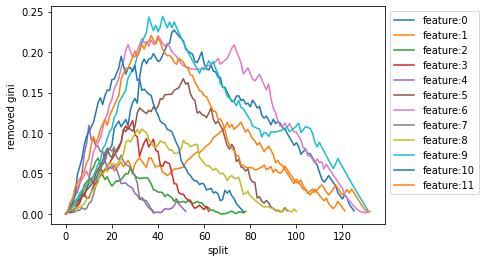

In [26]:
for i in range(12):
    plt.plot(gini[i],label="feature:%d"%i)
plt.ylabel("removed gini")
plt.xlabel("split")
plt.legend(bbox_to_anchor=(1,1), loc="upper left")

In [37]:
#max_feat,np.unique(X[:,max_feat])[gini[max_feat]==max_val][0],ober_all[max_feat][np.argmax(gini[max_feat])],max_val
print("optimal split is at feature",max_feat,"with split at:",np.unique(X[:,max_feat])[gini[max_feat]==max_val][0]," with removed gini:",max_val)

optimal split is at feature 9 with split at: 3.84  with removed gini: 0.2443078248581939


### Task 2.3

1. Implement a function `build_tree(X, t, depth)` which recursively builds a tree. Use the classes `Node` and `Leaf` as a data structure to build your tree.
2. Implement a function `predict_tree(tree, x)` which makes a prediction for sample `x`. Obtain scores for the `wine` dataset and compare to `sklearn.tree.DecisionTree`.
3. Switch back to the synthetic 2d dataset from the beginning (kernel methods). Compute scores and visualize the decisions in a 2d grid.

In [28]:
class Node:
    def __init__(self, left, right, n_feat, threshold):
        self.left = left
        self.right = right
        self.n_feat = n_feat
        self.threshold = threshold

class Leaf:
    def __init__(self, label):
        self.label = label


In [29]:
# Implement recursive tree function

def build_tree(X, t, depth, max_depth=3, n_labels=2):
    
    # ---------------- INSERT CODE ----------------------
    if(X.shape[0]==0):
        return(0)
    if(depth==max_depth):
        #np.argmin(np.abs(np.unique(t)-np.mean(t)))
        max_t=[]
        for ts in np.unique(t):
            max_t.append(sum(t==ts))
        return(Leaf(np.unique(t)[np.argmax(max_t)]))
    gini=[]
    for i in range(X.shape[1]):
        X_act = X[:,i]
        gini_act=[]
        classes = np.unique(X_act)
        for ober in classes:
            split1=t[X_act<ober]
            split2=t[X_act>=ober]
            gini_act.append(gini_impurity(t)-(len(split1)/len(t))*gini_impurity(split1)-(len(split2)/len(t))*gini_impurity(split2))
        gini.append(gini_act)
    maxes=[]
    for i in range(X.shape[1]):
        maxes.append(np.max(gini[i]))
    max_feat = np.argmax(maxes)
    max_val = np.max(maxes)
    #threshold = ober_all[max_feat][np.argmax(gini[max_feat])]
    max_ober=np.unique(X[:,max_feat])[gini[max_feat]==max_val][0]
    X_links = X[X[:,max_feat]<max_ober]
    X_rechts = X[X[:,max_feat]>=max_ober]
    t_links = t[X[:,max_feat]<max_ober]
    t_rechts = t[X[:,max_feat]>=max_ober]
    return Node(build_tree(X_links, t_links, depth+1, max_depth, n_labels),build_tree(X_rechts, t_rechts, depth+1, max_depth, n_labels),max_feat,max_ober)
        

    # ---------------- END CODE -------------------------

    
def predict_tree(node, x):
    
    # ---------------- INSERT CODE ----------------------
    if(x[node.n_feat]<node.threshold):
        return node.left
    return node.right


    # ---------------- END CODE -------------------------

In [30]:
# Build tree

tree = build_tree(X_train, t_train, 0, max_depth=3, n_labels=3)

In [31]:
# Calculate training and test scores
y_test_pred=[]
y_train_pred=[]
for i in range(X_train.shape[0]):
    note=predict_tree(tree, X_train[i])
    note=predict_tree(note, X_train[i])
    note=predict_tree(note, X_train[i])
    y_train_pred.append(note.label)
for i in range(X_test.shape[0]):
    note=predict_tree(tree, X_test[i])
    note=predict_tree(note, X_test[i])
    note=predict_tree(note, X_test[i])
    y_test_pred.append(note.label)
np.mean(y_test_pred==t_test),np.mean(y_train_pred==t_train)

(0.9056603773584906, 0.984)

In [32]:
# Calculate test score using sklearn
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0).fit(X_train,t_train)
clf.score(X_test,t_test),clf.score(X_train,t_train)

(0.9433962264150944, 1.0)

In [33]:
# Calculate test score for synthetic 2D dataset
X_2d, t_2d = np.load('nonlin_2d_data.npy')[:,:2], np.load('nonlin_2d_data.npy')[:, 2]
X_train, X_test, t_train, t_test = split_data(X_2d, t_2d, seed=1)
tree = build_tree(X_train, t_train, 0, max_depth=3, n_labels=2)
y_test_pred=[]
y_train_pred=[]
for i in range(X_train.shape[0]):
    note=predict_tree(tree, X_train[i])
    note=predict_tree(note, X_train[i])
    note=predict_tree(note, X_train[i])
    y_train_pred.append(note.label)
for i in range(X_test.shape[0]):
    note=predict_tree(tree, X_test[i])
    note=predict_tree(note, X_test[i])
    note=predict_tree(note, X_test[i])
    y_test_pred.append(note.label)
np.mean(y_test_pred==t_test),np.mean(y_train_pred==t_train)

(0.9333333333333333, 0.9885714285714285)

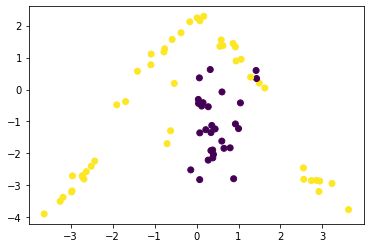

In [34]:
# Visualize
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test_pred)